# Speech Feature Extraction using OpenSMILE (GeMapsv01b + ComParE config)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import List, Optional

import opensmile
import pandas as pd
import socket
from typing import Tuple
import traceback
from scipy.io import wavfile
import numpy as np
from IPython.display import display
from tqdm.auto import tqdm
from multiprocessing import Pool

from speech_study.path_conf import loc_data_dir

from speech_study.audio_ptcpt_filtering import add_audio_mask


In [3]:
# configure user
USER = "jonas"
EXTRACTED_FEATS = False  # set this to False if you want to extract the features again

if socket.gethostname() == "gecko":
    BASE_PATH = Path("/media/aaa_contextaware/raw/uz_study")
elif USER.lower() == "mitchel":
    BASE_PATH = "D:/Data/EEG_Study_1/"  # Go check 1_audio_preprocess.py
else:
    raise ValueError("unknown user")

# DATA_PATH = BASE_PATH.joinpath("aligned_data")


# Extracting features

useful links:
* [opensmile config folder](https://github.com/audeering/opensmile/tree/v3.0.0/config)
* difference between GeMAPS versions [here](https://github.com/audeering/opensmile/blob/v3.0.0/config/gemaps/CHANGES.txt')

**note**: `eGeMAPS` is an _extended_ version of the GeMAPS

feature-level`
* `Functionals`: global segment based features (1 feature per segment)
* `LowLevelDescriptor`: sliding window features (1 feature per window)

In [4]:
func_gemaps = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)

lld_gemaps = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

# we will use the ComParE LLD to calculate frequency-based features on `F0final_sma`
lld_compare = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)


## Whole duration

In [6]:
EXTRACTED_FEATS = False

if not EXTRACTED_FEATS:
    df_gemaps_func_list: List[pd.DataFrame] = []
    df_gemaps_lld_list: List[pd.DataFrame] = []
    df_compare_lld_list: List[pd.DataFrame] = []

    def _extract_parse_smile_df(s: opensmile.Smile, f: Path) -> pd.DataFrame:
        """process the audio file with the given OpenSmile conf & add relevant metadata.

        Parameters
        ----------
        s: opensmile.Smile
            The OpenSmile feature extraction conf
        f: Union[Path, str]
            The file that will be processed

        Returns
        -------
        pd.DataFrame
            The DataFrame output of the processed file with additional metadata,
            i.e., the "fileName", the "fileNumber", and the "participantNum"

        """
        # 1. process the audio file with the given opensmile conf
        df_feat = s.process_file(str(f))
        df_feat = df_feat.reset_index(drop=False)
        # 2. add metadata; i.e., file-path, filename, file number, participant number
        df_feat["file"] = df_feat["file"].astype("str")

        df_feat["fileName"] = f.name
        df_feat["fileNum"] = pd.to_numeric(
            df_feat.fileName.map(lambda x: x.split(".")[0].split("_")[-1]),
            errors="coerce",
        )
        df_feat["participantNum"] = int(f.parent.name)
        return df_feat

    def _extract_opensmile_f(file: Path) -> Tuple[pd.DataFrame, ...]:
        # calculate the global utterance features
        return (
            _extract_parse_smile_df(func_gemaps, f=file),
            _extract_parse_smile_df(lld_gemaps, f=file),
            _extract_parse_smile_df(lld_compare, f=file),
        )

    # iterate over all the audio files
    out = None
    with Pool(processes=8) as pool:
        wav_files = list(list(BASE_PATH.glob("**/Audio/*/sentences_*.wav")))
        results = pool.imap_unordered(_extract_opensmile_f, wav_files)
        results = tqdm(results, total=len(wav_files))
        try:
            out = [f for f in results]
        except:
            traceback.print_exc()
            pool.terminate()
        finally:
            pool.close()
            pool.join()

    def _parse_concat_df(df_conc: pd.DataFrame) -> pd.DataFrame:
        """parse a just-concatenated DataFrame."""
        # Convert columns to categorical typ
        df_conc["file"] = df_conc["file"].astype("category")
        df_conc["fileName"] = df_conc["fileName"].astype("category")

        # Merge the OpenSmile feature dataframe with the SAM output
        return pd.merge(
            df_conc,
            pd.read_csv(loc_data_dir.joinpath("SAMsCompiled.csv")),
            on=["participantNum", "fileNum"],
        )

    # Parse the dataframes
    df_gemaps_func = _parse_concat_df(pd.concat([o[0] for o in out], ignore_index=True))
    df_gemaps_lld = _parse_concat_df(pd.concat([o[1] for o in out], ignore_index=True))
    df_compare_lld = _parse_concat_df(pd.concat([o[2] for o in out], ignore_index=True))

    # As the gemaps dataframe is used in further analysis, we already apply a 
    # filter to it
    add_audio_mask(df_gemaps_func)
    df_gemaps_func[~df_gemaps_func.bad_audio].reset_index(drop=True).to_parquet(
        loc_data_dir.joinpath("df_gemaps_func.parquet"), engine="fastparquet"
    )
    df_gemaps_lld.to_parquet(
        loc_data_dir.joinpath("df_gemaps_lld.parquet"), engine="fastparquet"
    )
    df_compare_lld.to_parquet(
        loc_data_dir.joinpath("df_compare_lld.parquet"), engine="fastparquet"
    )

    # Delete future unused variables
    del (
        out,
        df_gemaps_func_list,
        df_gemaps_lld_list,
        df_compare_lld_list,
        _parse_concat_df,
        _extract_parse_smile_df,
    )

else:  # Already extracted features -> load the dataframes
    df_gemaps_func = pd.read_parquet(loc_data_dir.joinpath("df_gemaps_func.parquet"))
    df_gemaps_lld = pd.read_parquet(loc_data_dir.joinpath("df_gemaps_lld.parquet"))
    df_compare_lld = pd.read_parquet(loc_data_dir.joinpath("df_compare_lld.parquet"))

  0%|          | 0/809 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 851, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_364209/3191651270.py", line 54, in <module>
    out = [f for f in results]
  File "/tmp/ipykernel_364209/3191651270.py", line 54, in <listcomp>
    out = [f for f in results]
  File "/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/tqdm/notebook.py", line 257, in __iter__
    for obj in super(tqdm_notebook, self).__iter__():
  File "/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/tqdm/std.py", line 1180, in __iter__
    for obj in iterable:
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 856, in next
    self._cond.wait(timeout)
  File "/usr/lib/python3.8/threading.py", line 302, in wa

TypeError: 'NoneType' object is not iterable

In [ ]:
from opensmile.core.SMILEapi import smileapi_path
smileapi_path

'/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/opensmile/core/bin/linux/libSMILEapi.so'

## Fixed duration

### End of utterance

In [5]:
DURATION_S = 7

In [6]:
def _extract_parse_smile_duration(
    s: opensmile.Smile, f: Path, duration_s: float
) -> pd.DataFrame:
    sr, wav_arr = wavfile.read(f)

    # we extract features until the penultimate second of the utterance
    t_end = (wav_arr.shape[0] / sr) - 1
    t_start = max(1, t_end - duration_s)

    df_feat = s.process_file(
        file=f,
        start=t_start,
        end=t_end,
    )

    df_feat = df_feat.reset_index(drop=False)
    df_feat["file"] = df_feat["file"].astype(str)
    df_feat["fileName"] = f.name
    df_feat["fileNum"] = pd.to_numeric(
        df_feat.fileName.map(lambda x: x.split(".")[0].split("_")[-1]),
        errors="coerce",
    )
    df_feat["participantNum"] = int(f.parent.name)
    return df_feat


def _extract_opensmile_f_duration(file_duration) -> Tuple[pd.DataFrame, ...]:
    file, duration = file_duration
    # calculate the global utterance features
    return (
        _extract_parse_smile_duration(func_gemaps, f=file, duration_s=duration),
    )

def _extract_opensmile_f_duration(file_duration) -> Tuple[pd.DataFrame, ...]:
    file, duration = file_duration
    # calculate the global utterance features
    return (
        _extract_parse_smile_duration(func_gemaps, f=file, duration_s=duration),
    )

# iterate over all the audio files
out = None
with Pool(processes=8) as pool:
    wav_files = list(list(BASE_PATH.glob("**/Audio/*/sentences_*.wav")))
    wav_files = [(wf, DURATION_S) for wf in wav_files]
    results = pool.imap_unordered(_extract_opensmile_f_duration, wav_files)
    results = tqdm(results, total=len(wav_files))
    try:
        out = [f for f in results]
    except:
        traceback.print_exc()
        pool.terminate()
    finally:
        pool.close()
        pool.join()

def _parse_concat_df(df_conc: pd.DataFrame) -> pd.DataFrame:
    """parse a just-concatenated DataFrame."""
    # Convert columns to categorical typ
    df_conc["file"] = df_conc["file"].astype("category")
    df_conc["fileName"] = df_conc["fileName"].astype("category")

    # Merge the OpenSmile feature dataframe with the SAM output
    return pd.merge(
        df_conc,
        pd.read_csv(loc_data_dir.joinpath("SAMsCompiled.csv")),
        on=["participantNum", "fileNum"],
    )


df_gemaps_func_dur_end = _parse_concat_df(pd.concat([o[0] for o in out], ignore_index=True))

del (
    out,
    _extract_opensmile_f_duration,
    _parse_concat_df,
    _extract_parse_smile_duration,
)


/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/opensmile/core/smile.py:308: UserWarning: Segment too short, filling with NaN.
  warnings.warn(


  0%|          | 0/809 [00:00<?, ?it/s]

/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/opensmile/core/smile.py:308: UserWarning: Segment too short, filling with NaN.
  warnings.warn(
/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/opensmile/core/smile.py:308: UserWarning: Segment too short, filling with NaN.
  warnings.warn(
/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/opensmile/core/smile.py:308: UserWarning: Segment too short, filling with NaN.
  warnings.warn(
/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/opensmile/core/smile.py:308: UserWarning: Segment too short, filling with NaN.
  warnings.warn(
/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/opensmile/core/smile.py:308: UserWarning: Segment too short, filling with NaN.
  warnings.warn(
/home/jonas/.cache/pypoetry/virtualenvs/

In [7]:
df_gemaps_func_dur_end.to_parquet(
    loc_data_dir / "df_gemaps_func_dur_end.parquet", engine="fastparquet"
)


In [8]:
df_gemaps_func_dur_end

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,fileName,fileNum,participantNum,arousal,valence,dominance
0,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:22.559541667,0 days 00:00:29.559541667,29.108330,0.173642,28.156876,30.329102,32.517506,4.360630,373.136780,...,0.167917,0.163095,0.113810,0.100023,sentences_occ_0.wav,0.0,10,3,5,6
1,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:25.439541667,0 days 00:00:32.439541667,28.106506,0.231584,24.435486,30.585367,32.227222,7.791737,456.986908,...,0.161905,0.121601,0.163684,0.129786,sentences_occ_1.wav,1.0,10,4,5,5
2,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:22.399541667,0 days 00:00:29.399541667,31.191338,0.123395,30.306198,31.975500,33.270496,2.964298,446.350677,...,0.206316,0.181723,0.145556,0.170301,sentences_occ_2.wav,2.0,10,6,4,6
3,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:22.199541667,0 days 00:00:29.199541667,30.395613,0.176271,29.278442,31.423901,33.617992,4.339550,153.023468,...,0.232105,0.153025,0.119444,0.142067,sentences_occ_4.wav,4.0,10,3,5,5
4,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:21.559541667,0 days 00:00:28.559541667,32.257095,0.121216,30.783831,32.767826,34.515903,3.732073,620.930786,...,0.213684,0.157119,0.143529,0.180357,sentences_occ_5.wav,5.0,10,5,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:14.839541667,0 days 00:00:21.839541667,30.062290,0.227711,22.618893,32.560211,34.737453,12.118561,237.711899,...,0.174000,0.151308,0.157368,0.116612,sentences_occ_4.wav,4.0,83,4,7,8
707,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:17.839541667,0 days 00:00:24.839541667,29.971357,0.257495,21.319893,32.862839,36.372032,15.052139,430.811646,...,0.191304,0.184374,0.096190,0.064326,sentences_occ_0.wav,0.0,83,6,5,8
708,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:15.479541667,0 days 00:00:22.479541667,32.797699,0.164490,31.787439,33.245785,36.059074,4.271635,394.381378,...,0.205263,0.149644,0.155882,0.185157,sentences_occ_7.wav,7.0,83,7,5,8
709,/media/aaa_contextaware/raw/uz_study/study_dat...,0 days 00:00:17.839541667,0 days 00:00:24.839541667,31.402668,0.203855,31.624950,33.234035,35.277309,3.652359,339.803528,...,0.173913,0.167065,0.128947,0.128878,sentences_occ_8.wav,8.0,83,6,6,8


### Start of utterance

In [ ]:
def _extract_parse_smile_duration(
    s: opensmile.Smile, f: Path, duration_s: float
) -> pd.DataFrame:
    # we extract features until the penultimate second of the utterance
    t_start = 1
    t_end = duration_s + 1

    df_feat = s.process_file(
        file=f,
        start=t_start,
        end=t_end,
    )

    df_feat = df_feat.reset_index(drop=False)
    df_feat["file"] = df_feat["file"].astype(str)
    df_feat["fileName"] = f.name
    df_feat["fileNum"] = pd.to_numeric(
        df_feat.fileName.map(lambda x: x.split(".")[0].split("_")[-1]),
        errors="coerce",
    )
    df_feat["participantNum"] = int(f.parent.name)
    return df_feat


def _extract_opensmile_f_duration(file_duration) -> Tuple[pd.DataFrame, ...]:
    file, duration = file_duration
    # calculate the global utterance features
    return (
        _extract_parse_smile_duration(func_gemaps, f=file, duration_s=duration),
    )

def _extract_opensmile_f_duration(file_duration) -> Tuple[pd.DataFrame, ...]:
    file, duration = file_duration
    # calculate the global utterance features
    return (
        _extract_parse_smile_duration(func_gemaps, f=file, duration_s=duration),
    )

# iterate over all the audio files
out = None
with Pool(processes=8) as pool:
    wav_files = list(list(BASE_PATH.glob("**/Audio/*/sentences_*.wav")))
    wav_files = [(wf, DURATION_S) for wf in wav_files]
    results = pool.imap_unordered(_extract_opensmile_f_duration, wav_files)
    results = tqdm(results, total=len(wav_files))
    try:
        out = [f for f in results]
    except:
        traceback.print_exc()
        pool.terminate()
    finally:
        pool.close()
        pool.join()

def _parse_concat_df(df_conc: pd.DataFrame) -> pd.DataFrame:
    """parse a just-concatenated DataFrame."""
    # Convert columns to categorical typ
    df_conc["file"] = df_conc["file"].astype("category")
    df_conc["fileName"] = df_conc["fileName"].astype("category")

    # Merge the OpenSmile feature dataframe with the SAM output
    return pd.merge(
        df_conc,
        pd.read_csv(loc_data_dir.joinpath("SAMsCompiled.csv")),
        on=["participantNum", "fileNum"],
    )


df_gemaps_func_dur_begin = _parse_concat_df(pd.concat([o[0] for o in out], ignore_index=True))

del (
    out, # TODO
    _extract_opensmile_f_duration,
    _parse_concat_df,
    _extract_parse_smile_duration,
)

In [ ]:
df_gemaps_func_dur_begin.to_parquet(
    loc_data_dir / "df_gemaps_func_dur_begin.parquet", engine="fastparquet"
)


/home/jonas/.cache/pypoetry/virtualenvs/speech-study-E7pgW727-py3.8/lib/python3.8/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


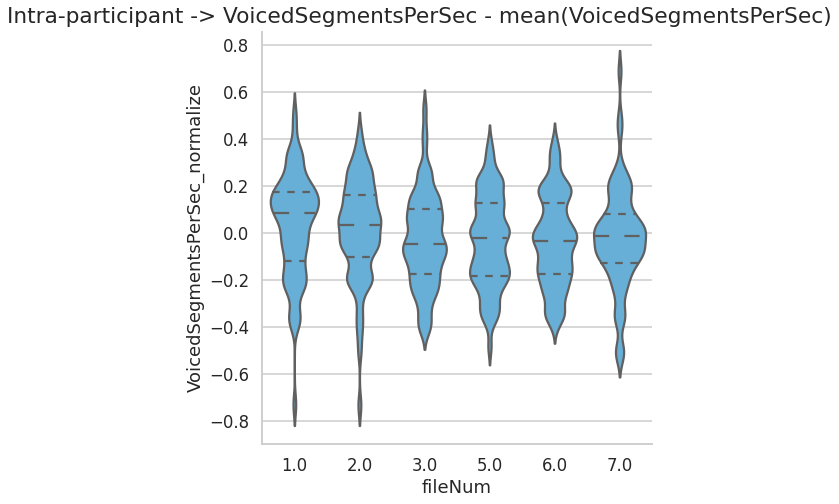

In [ ]:
col_of_interest = "VoicedSegmentsPerSec"

df_gemaps_func[f"{col_of_interest}_normalize"] = df_gemaps_func[
    col_of_interest
] - df_gemaps_func.groupby("participantNum")[f"{col_of_interest}"].transform("mean")

sns.set_context("talk")
sns.set_style("whitegrid")
g = sns.catplot(
    data=df_gemaps_func[
        (~df_gemaps_func.bad_audio)
        & (df_gemaps_func.condition.notna())
        & (df_gemaps_func["HNRdBACF_sma3nz_amean"] > 0)
    ],
    x="fileNum",
    y=f"{col_of_interest}_normalize",
    # row="speech_feature",
    height=7,
    bw=0.2,
    kind="violin",
    palette=["#56B4E9"],  # "#E69F00"],
    sharey=False,
    sharex=False,
    inner="quartile",
)
# g.set_titles("{row_name}")
g.fig.suptitle(
    f"Intra-participant -> {col_of_interest} - mean({col_of_interest})", y=1.01
)
plt.subplots_adjust(wspace=0.6, hspace=0.3)


## Extract `F0`-range from the LLD's

use `tsflex` to extract FO-quantile-range based features from the LLD's

In [7]:
from tsflex.features import FuncWrapper
from tsflex.features.utils import make_robust
import numpy as np


In [8]:
# ------------- define some additional feature functions -------------
def quantile_nz(a: np.ndarray, q=List[float]) -> List[Optional[float]]:
    """non-zero quantiles"""
    a_nz = a[a > 0]
    if len(a_nz):
        return np.quantile(a_nz, q=q)
    else:
        return [None] * len(q)


def nonzero_count(a: np.ndarray) -> int:
    return sum(a > 0)


def return_func_series_list(a: np.ndarray, f_list: List[FuncWrapper]) -> pd.Series:
    """apply each function on a and return a pd.Series with index `feat_name`
    and value `feat_value`.
    """
    s = pd.Series(dtype="float64")
    for f in f_list:
        s = pd.concat([s, pd.Series(data=f(a), index=f.output_names)])
    return s.sort_index()


qs = sum([[1 - q, q] for q in [0, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2]], []) + [0.5]
display(str(qs))


'[1, 0, 0.99, 0.01, 0.98, 0.02, 0.97, 0.03, 0.95, 0.05, 0.9, 0.1, 0.85, 0.15, 0.8, 0.2, 0.5]'

### GeMAPS LLD

Calculate the F0-range features on the gemaps LLD's

In [9]:
df_gemaps_lld.filter(like="F0").columns
# logRelF0-H1-H2_sma3nz -> log freq difference between the harmonics
# SMA -> moving average window
# NZ -> no-zero


Index(['F0semitoneFrom27.5Hz_sma3nz', 'logRelF0-H1-H2_sma3nz',
       'logRelF0-H1-A3_sma3nz', 'F1amplitudeLogRelF0_sma3nz',
       'F2amplitudeLogRelF0_sma3nz', 'F3amplitudeLogRelF0_sma3nz'],
      dtype='object')

In [10]:
# define the signal on which the function will be performed, and the functions
s_name = "F0semitoneFrom27.5Hz_sma3nz"

f_gemaps_lld_funcs: List[FuncWrapper] = [
    make_robust(
        FuncWrapper(quantile_nz, output_names=[s_name + f"_q={q}" for q in qs], q=qs),
        min_nb_samples=3,
        passthrough_nans=False,
    ),
    make_robust(FuncWrapper(nonzero_count, output_names=[f"{s_name}_nzcount"])),
]

# Apply the functions on each group
df_gemaps_lld_F0 = (
    df_gemaps_lld.groupby(by=["fileName", "fileNum", "participantNum"])[[s_name]]
    .apply(lambda x: return_func_series_list(x.values, f_list=f_gemaps_lld_funcs))
    .reset_index()
)
display(df_gemaps_lld_F0)

df_gemaps_lld_F0.to_parquet(loc_data_dir.joinpath("df_gemaps_lld_F0.parquet"))


,fileName,fileNum,participantNum,F0semitoneFrom27.5Hz_sma3nz_nzcount,F0semitoneFrom27.5Hz_sma3nz_q=0,F0semitoneFrom27.5Hz_sma3nz_q=0.01,F0semitoneFrom27.5Hz_sma3nz_q=0.02,F0semitoneFrom27.5Hz_sma3nz_q=0.03,F0semitoneFrom27.5Hz_sma3nz_q=0.05,F0semitoneFrom27.5Hz_sma3nz_q=0.1,...,F0semitoneFrom27.5Hz_sma3nz_q=0.2,F0semitoneFrom27.5Hz_sma3nz_q=0.5,F0semitoneFrom27.5Hz_sma3nz_q=0.8,F0semitoneFrom27.5Hz_sma3nz_q=0.85,F0semitoneFrom27.5Hz_sma3nz_q=0.9,F0semitoneFrom27.5Hz_sma3nz_q=0.95,F0semitoneFrom27.5Hz_sma3nz_q=0.97,F0semitoneFrom27.5Hz_sma3nz_q=0.98,F0semitoneFrom27.5Hz_sma3nz_q=0.99,F0semitoneFrom27.5Hz_sma3nz_q=1
0,sentences_occ_0.wav,0.0,2,1277.0,12.435101,13.466747,13.814878,14.208255,15.278906,19.285241,...,23.580828,33.262379,34.514874,34.700854,34.983155,35.451363,35.759081,36.293914,37.114670,37.659714
1,sentences_occ_0.wav,0.0,3,1412.0,12.439996,13.128016,13.414092,13.858814,14.567879,16.099171,...,24.109766,34.545498,35.626716,35.856668,36.069822,36.454732,36.764560,37.275663,37.682383,38.439503
2,sentences_occ_0.wav,0.0,4,1425.0,12.037051,12.537432,12.777922,12.877586,13.102240,13.631784,...,19.587413,23.304682,24.538245,24.755706,25.053704,25.609200,25.926469,26.324248,26.992587,34.139542
3,sentences_occ_0.wav,0.0,5,1460.0,12.260077,13.294396,13.548588,13.964571,14.831079,18.212867,...,32.812402,34.778267,36.406091,36.671796,37.035429,37.782782,37.973423,38.117235,38.503780,39.581223
4,sentences_occ_0.wav,0.0,6,1387.0,12.124546,12.720390,13.350441,13.605247,14.101310,18.546955,...,30.957187,33.413910,36.554290,37.356292,37.810281,38.729762,39.351277,39.905043,40.727717,41.366283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9238,sentences_occ_99.wav,8.0,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9239,sentences_occ_99.wav,8.0,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9240,sentences_occ_99.wav,8.0,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9241,sentences_occ_99.wav,8.0,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ComPaRE LLD

Calculate the F0-range features using the COMPARE LLD's.

In [11]:
df_compare_lld.filter(like="F0").columns


Index(['F0final_sma'], dtype='object')

In [12]:
s_name = "F0final_sma"

f_compare_lld_funcs: List[FuncWrapper] = [
    make_robust(
        FuncWrapper(quantile_nz, output_names=[s_name + f"_q={q}" for q in qs], q=qs),
        min_nb_samples=3,
        passthrough_nans=False,
    ),
    make_robust(FuncWrapper(nonzero_count, output_names=[f"{s_name}_nzcount"])),
]

df_compare_lld_F0 = df_compare_lld.groupby(
    by=["fileName", "fileNum", "participantNum"]
)[[s_name]].apply(
    lambda x: return_func_series_list(x.values, f_list=f_compare_lld_funcs)
)
display(df_compare_lld_F0)

df_compare_lld_F0.to_parquet(loc_data_dir.joinpath("df_compare_lld_F0.parquet"))


F0final_sma_nzcount  \
fileName             fileNum participantNum                        
sentences_occ_0.wav  0.0     2                            1305.0   
                             3                            1438.0   
                             4                            1484.0   
                             5                            1484.0   
                             6                            1445.0   
...                                                          ...   
sentences_occ_99.wav 8.0     79                              NaN   
                             80                              NaN   
                             81                              NaN   
                             82                              NaN   
                             83                              NaN   

                                             F0final_sma_q=0  \
fileName             fileNum participantNum                    
sentences_occ_0.wav  0.0     2                     52.270561   
                             3                     52.501904   
                             4                     52.134758   
                             5                     52.093735   
                             6                     52.266987   
...                                                      ...   
sentences_occ_99.wav 8.0     79                          NaN   
                             80                          NaN   
                             81                          NaN   
                             82                          NaN   
                             83                          NaN   

                                             F0final_sma_q=0.01  \
fileName             fileNum participantNum                       
sentences_occ_0.wav  0.0     2                        55.465402   
                             3                        55.533387   
                             4                        53.612640   
                             5                        54.789709   
                             6                        53.462184   
...                                                         ...   
sentences_occ_99.wav 8.0     79                             NaN   
                             80                             NaN   
                             81                             NaN   
                             82                             NaN   
                             83                             NaN   

                                             F0final_sma_q=0.02  \
fileName             fileNum participantNum                       
sentences_occ_0.wav  0.0     2                        58.989787   
                             3                        58.160414   
                             4                        54.619430   
                             5                        56.277618   
                             6                        55.384617   
...                                                         ...   
sentences_occ_99.wav 8.0     79                             NaN   
                             80                             NaN   
                             81                             NaN   
                             82                             NaN   
                             83                             NaN   

                                             F0final_sma_q=0.03  \
fileName             fileNum participantNum                       
sentences_occ_0.wav  0.0     2                        60.276768   
                             3                        59.298107   
                             4                        55.355605   
                             5                        58.652993   
                             6                        56.776181   
...                                                         ...   
sentences_occ_99.wav 8.0     79                

In [13]:
del df_compare_lld, df_gemaps_lld


# Join into one big dataframe

In [9]:
df_feat_tot = df_gemaps_func.merge(
    df_gemaps_lld_F0.reset_index(), on=["participantNum", "fileNum", "fileName"]
).merge(df_compare_lld_F0.reset_index(), on=["participantNum", "fileNum", "fileName"])
df_feat_tot


NameError: name 'df_gemaps_func' is not defined

In [19]:
# save the features
df_feat_tot.to_feather(loc_data_dir.joinpath("df_speech_feat_tot.feather"))
